In [2]:
using JuMP, GLPK
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics
using Distributions
using StatsBase

In [3]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

function plot_locations(x, title)
    
    gr()
    Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), title = title, legend = false)
    
end

function plot_stations(y, title)
   
    plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);
        
    if voronoi == true
        plot(tess, color = :green, alpha = 0.4)
    end

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    for i = 1:n
        scatter!(X[i], Y[i], aspect_ratio=:equal, markersize = 3, legend = false, labels = "Assigned to $i") # Plot EVs (differente color by each Station)
    end
        
    for i=1:m
        plot!([x[i,1],y[assigned_index[i],1]],[x[i,2],y[assigned_index[i],2]],color=:black, alpha = 0.2, labels = "") 
    end
    
    scatter!(y[:,1], y[:,2], markersize = 8, label = "Stations", markershape = :star, color=:white) # Plot Stations
    annotate!([(points[i][1] + 0.04, points[i][2] + 0.00, text(i, :black)) for i in 1:n]) # Add Station Number
end

function delete_row(matrix, row_index)
    
    return matrix[setdiff(1:end, row_index), :];
    
end

function random_points(size, dx, dy)
   
    rand_x = rand(dx, (size,1))
    rand_y = rand(dy, (size,1))
    
    random_point = hcat(rand_x, rand_y);
    
    return random_point;
    
end

function Geneterate_Ev_distribution(m, congestion_centers)
    
    #Random.seed!(40)

    x = [0 0]
    
    for congestion_point in congestion_centers
    
        mean_x = congestion_point[1];
        mean_y = congestion_point[2];
        variance_x = congestion_point[3];
        variance_y = congestion_point[4];
        amount_of_evs = Int(m * (congestion_point[5] / 100));

        dx = Distributions.Normal(mean_x, variance_x)
        dy = Distributions.Normal(mean_y, variance_y)

        new_points = random_points(amount_of_evs, dx, dy)

        x = vcat(x, new_points)  

    end

    x = delete_row(x, 1);
    
    return sortslices(x, dims = 1);
    
end

function Solve_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
    
    q = ones(m,1);
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .- s_max .<= zeros(1,n)) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)
    
    Pi = value.(Pi) 

    s = sum(Pi, dims = 1);
   
    mu = dual.(con)
    return s, abs.(mu);
    
end

function Print_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
    
    q = ones(m,1);
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .- s_max .<= zeros(1,n)) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)   
    
    println(dual.(con))

    Pi = value.(Pi) 
    
    plot_assignments(x, y, Pi)

    
end

struct Arrival
    stations :: Vector{Float64}
    ArrivalTime::Float64
    ChargeTime::Float64
end

function get_charged_stations_indexes(arrivals, t)
    
    # Finds all indexes of rows that arrival time + charged time is greater than
    # actual time
    return findall(arrival -> t >= arrival.ArrivalTime + arrival.ChargeTime, arrivals)
end

function has_any_car_been_charged(s_charged_indexes)
    return size(s_charged_indexes)[1] > 0
end

function convert_vector_to_matrix(vector)
    return reduce(hcat,vector)';
end

function create_arrival(s, t, dist)
   charge_time = rand(dist)
   charge_time = round(charge_time, digits=1)
   return Arrival(s[1,:], t, charge_time)
end

function get_stations(arrivals)
    return map(arrival ->arrival.stations, arrivals)
end

function get_total_stations_assignment(arrivals)
    stations = get_stations(arrivals)
    stations_total = sum(stations, dims = 1)
    stations_total = convert_vector_to_matrix(stations_total)
    return stations_total
end

function probability_of_charged(t)
    a = 1/200
    p = 1 - exp(-a*t)
    return p
end

function has_car_charged(t)
    p = probability_of_charged(t)
    n = rand()
    return n < p  
end

function plot_per_station(time, stations_per_time)
    number_of_stations = length(stations_per_time[1])
    
    attribute_per_stations = []

    for station_number = 1:number_of_stations
        attribute_of_station = map(attribute -> attribute[station_number], stations_per_time)
        push!(attribute_per_stations, attribute_of_station)
    end

    plot(time, attribute_per_stations)
end

plot_per_station (generic function with 1 method)

# Evs location

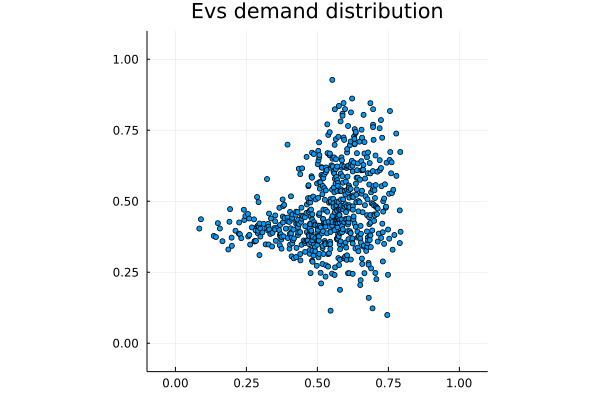

In [4]:
congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

m = 600;

x = Geneterate_Ev_distribution(m, congestion_centers);

plot_locations(x, "Evs demand distribution")

# Stations locations

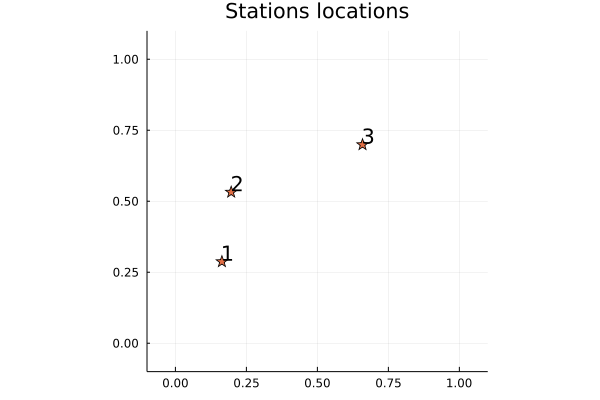

In [15]:
Random.seed!(23)

d = Distributions.Normal(0.5, 0.22)

n = 3;

y = sortslices(rand(d, (n,2)), dims = 1);

plot_stations(y, "Stations locations")

# Dynamic functions

# Run Dynamic

[0.0 0.0 0.0]


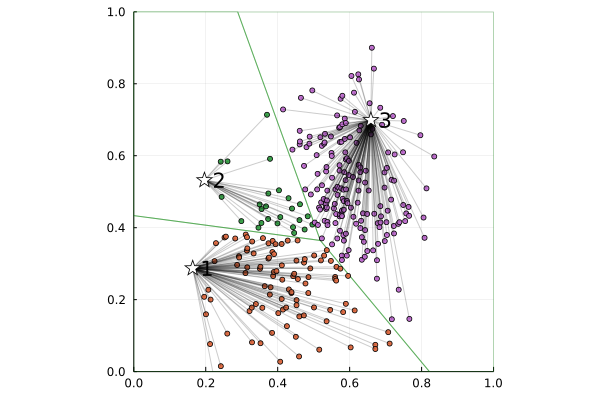

In [16]:
congestion_centers = [(0.6, 0.5, 0.1, 0.15, 65), (0.4, 0.3, 0.13, 0.12, 35)];

s_max = 250 * ones(1, n);

m = 300;
x = Geneterate_Ev_distribution(m, congestion_centers);
norm = 2;

C = get_cost_matrix(x, y, norm);

s = Print_Model(C, s_max)

In [17]:
# Cars
m = 100;
congestion_centers = [(0.6, 0.5, 0.1, 0.15, 65), (0.4, 0.3, 0.13, 0.12, 35)];

# Time
t = 0;
dt = 1;
t_final = 200;

# Distributions
dist_arrivals = Poisson(10)
dist_charges = Poisson(50)

# First arrival time
previous_arrival_time = t;
arrival_time = rand(dist_arrivals);

arrivals = Arrival[];

arrival_times = [];
occupations = [];
T = [];
mus = [];

# Stations max capacity
max_capacity = 250;
s_max = max_capacity * ones(1,n);

while t <= t_final
    
    charged_indexes = get_charged_stations_indexes(arrivals, t)

    #Departure
    if has_any_car_been_charged(charged_indexes)
               
        charged_stations_arrivals = arrivals[charged_indexes]
        
        charged_stations_total_assignment = get_total_stations_assignment(charged_stations_arrivals)
        
        s_max = s_max + charged_stations_total_assignment;
        
        deleteat!(arrivals, charged_indexes)
        
        charged_stations = get_stations(charged_stations_arrivals)
        
        println("t: $t | Departure $charged_stations | Max capacity $s_max");
        
    end
    
    # arrival happened
    if t >= previous_arrival_time + arrival_time
            
        x = Geneterate_Ev_distribution(m, congestion_centers);
        C = get_cost_matrix(x, y, norm);
        
        s, mu = Solve_Model(C ,s_max);
        s_max = s_max - s;
         
        arrival = create_arrival(s, t, dist_charges)
        push!(arrivals, arrival)
        push!(arrival_times, t)
        push!(mus,mu)
        
        charge_time = arrival.ChargeTime;
        println("t: $t | Arrival $s | Max capacity $s_max | Charge time: $charge_time");
        
        previous_arrival_time = t;
        arrival_time = rand(dist_arrivals);
    end
    
    occupation = max_capacity .- s_max;
    push!(occupations, occupation)    
    push!(T,t);
    t = t + dt;
          
end

t: 12 | Arrival [35.0 11.0 54.0] | Max capacity [215.0 239.0 196.0] | Charge time: 53.0
t: 21 | Arrival [29.0 8.0 63.0] | Max capacity [186.0 231.0 133.0] | Charge time: 48.0
t: 33 | Arrival [29.0 9.0 62.0] | Max capacity [157.0 222.0 71.0] | Charge time: 51.0
t: 40 | Arrival [30.0 11.0 59.0] | Max capacity [127.0 211.0 12.0] | Charge time: 54.0
t: 47 | Arrival [43.0 45.0 12.0] | Max capacity [84.0 166.0 0.0] | Charge time: 38.0
t: 56 | Arrival [43.0 57.0 0.0] | Max capacity [41.0 109.0 0.0] | Charge time: 48.0
t: 65 | Departure [[35.0, 11.0, 54.0]] | Max capacity [76.0 120.0 54.0]
t: 65 | Arrival [33.0 13.0 54.0] | Max capacity [43.0 107.0 0.0] | Charge time: 63.0
t: 69 | Departure [[29.0, 8.0, 63.0]] | Max capacity [72.0 115.0 63.0]
t: 76 | Arrival [32.0 8.0 60.0] | Max capacity [40.0 107.0 3.0] | Charge time: 41.0
t: 84 | Departure [[29.0, 9.0, 62.0]] | Max capacity [69.0 116.0 65.0]
t: 85 | Departure [[43.0, 45.0, 12.0]] | Max capacity [112.0 161.0 77.0]
t: 90 | Arrival [27.0 11.0 

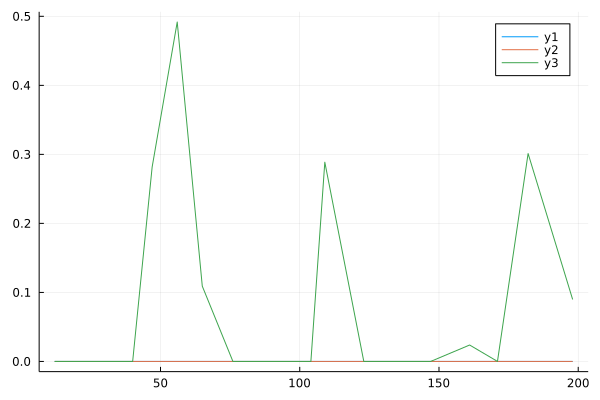

In [18]:
plot_per_station(arrival_times, mus)

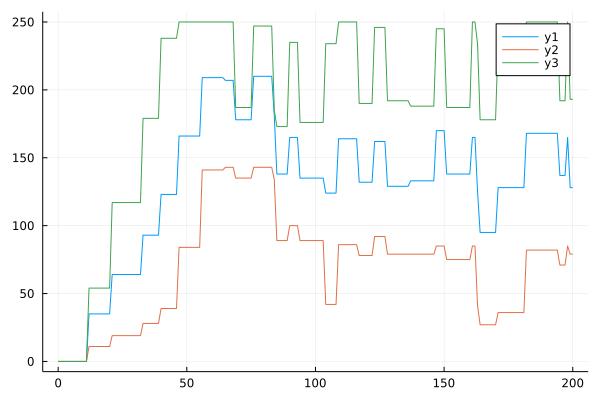

In [19]:
plot_per_station(T, occupations)